In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import Machine, generate_objects, BunchTracker, track, compare_traces, compare_projections
from test_tools import particle_position_difference, trace_difference

from PyHEADTAIL.feedback.feedback import IdealBunchFeedback,IdealSliceFeedback,OneboxFeedback
from PyHEADTAIL.feedback.processors.multiplication import ChargeWeighter
from PyHEADTAIL.feedback.processors.linear_transform import Averager
from PyHEADTAIL.feedback.processors.misc import Bypass

np.random.seed(0)

PyHEADTAIL v1.13.0.21
(dirty git work tree)


--> Use the longitudinal_tracking module instead.

PyHEADTAIL_feedback v0.2




/home/lmether/Desktop/PyHEADTAIL_multibunch_merge/PyHEADTAIL_develop/PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


# PyHEADTAIL feedback module

This series of tests/examples shows how to include models of transverse feedback systems to PyHEADTAIL simulations. It is assumed that the user knows basics of PyHEADTAIL, i.e. how to construct and track beam and what is one_turn_map. Thus, these tests focus on building different models of transverse feedback systems to the one turn map and testing them.

In order to avoid writing unnecessary code here, the bunch, slicer and transfer maps are created by using functions and classes in the file 'test_tools.py' of this folder.

## 001 ideal feedbacks
This test tests and demonstrates ideal models for a feedback system.

### Basic parameters and elements for the simulations

In [2]:
n_macroparticles = 10000
n_slices = 20
n_segments = 5
n_sigma_z = 3
# n_sigma_z = 6

n_turns = 150

# Longitudinal motion of the bunch is not taken into account by default, but it can be included by uncommenting
# the line below
machine = Machine(n_segments=n_segments)
#machine = Machine(Q_s = 0.0020443)

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(machine, n_macroparticles, n_slices,n_sigma_z)

*** I am rank 0 - my buckets are [0]


### Initial bunch kick
Creates an artificially (slice-by-slice) kicked bunch, which will be damped by using different feedback systems. 

In [3]:
slice_set = bunch_ref.get_slices(slicer_ref, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

# Random slice kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]

# A bunch kick
# kick_x = 0.003*np.ones(n_slices)
# kick_y = 0.003*np.ones(n_slices)

Tracks the kicked bunch without damper as reference data

In [4]:
bunch_init = copy.deepcopy(bunch_ref)

# tracker is an object which stores turn-by-turn data from the tracked bunch
tracker_ref = BunchTracker(bunch_init)

one_turn_map = [i for i in trans_map] #+ [long_map]

# function track 
track(n_turns, bunch_init,one_turn_map,tracker_ref)

### Feedback settings
The definition of *gain* is that it is a fraction of the measured (pass band) oscillations corrected per turn. Because each axis of the beam is a 2D object (x and x' coordinates) and the damper affects only one plane at a time, the damping time $\tau_d$ in turns is
    
$\tau_d = \frac{2}{gain}$

There are two ways to set a gain value. If only one value is given, the same value is used both in horizontal and vertical planes. If two values are given (gain_x, gain_y), separate values are used for horizontal and
vertical planes.

In [5]:
feedback_gain = 0.1
# feedback_gain = (0.1,0.4)

### Ideal reference implementations

Ideal feedbacks for a bunch-by-bunch feedback and a slice-by-slice feedback are implemented separately in order to test the actual framework. Reference data from these separate implementations are calculated here

In [6]:
# The bunch is created by copying the bunch created earlier
bunch_IdealBunchFB = copy.deepcopy(bunch_ref)
tracker_IdealBunchFB = BunchTracker(bunch_IdealBunchFB)

feedback_map = IdealBunchFeedback(feedback_gain)
one_turn_map = [i for i in trans_map] + [feedback_map]#  + [long_map]
track(n_turns, bunch_IdealBunchFB, one_turn_map, tracker_IdealBunchFB)


bunch_IdealSliceFB = copy.deepcopy(bunch_ref)
tracker_IdealSliceFB = BunchTracker(bunch_IdealSliceFB)
slicer_IdealSliceFB = copy.deepcopy(slicer_ref)
feedback_map = IdealSliceFeedback(feedback_gain,slicer_IdealSliceFB)
one_turn_map = [i for i in trans_map] + [feedback_map]#  + [long_map]
track(n_turns, bunch_IdealSliceFB, one_turn_map, tracker_IdealSliceFB)

### OneboxFeedback
The feedback framework allows accurate implementations of transverse feedback systems, i.e. an arbitrary number of pickups and kickers can be added to the one turn map and signal processing from pickups to kickers can be modeled with all the details. However, if all the details are taken into account the model soon becomes complex and messy. Thus, we start with a simple example, where a pickup and a kicker are located in the same location of the one turn map. This is a rather good approximation because in most of the cases the betatron phase advance between a pickup and a kicker can be corrected well in feedback systems.

When a pickup and a kicker locate in the same place, a feedback object for the one turn map can be created by using OneboxFeedback(...). At first OneboxFeedback reads x' (or x if chosen) values of the bunch, which is an input signal for the actual signal processing model.  Then the signal is processed by passing it through a given list of signal
processors, which is the model for the feedback system.  Each signal processor in the list represents an elementary analog or digital signal processing step. Finally, the processed signal is multiplied by the gain value, which gives corrections to the x' (or x if chosen) values.

By default, OneboxFeedback reads and corrects x' coordinates, but the pickup and kicker axes can be chosen by giving *'divergence'* or *'displacement'* to the input parameters, namely *pickup_axis* and *kicker_axis*. Note that if *pickup_axis* and *kicker_axis* have different values, the beta function values at the OneboxFeedback location must be given also as an input parameter. In most of the cases, the choice of the axis does not affect results.


#### Ideal slice-by-slice feedback

The simples feedback to implement is an ideal slice-by-slice feedback, which, correct ideally intra bunch oscillations. It takes *x'* and *y'* values of the PyHEADTAIL slices and correct them instantly by the fraction of the gain. Because in this case signal is not modified by the signal processors, the signal processor lists contain only a Bypass processor. 

In [7]:
bunch_Onebox_slice = copy.deepcopy(bunch_ref)
tracker_Onebox_slice = BunchTracker(bunch_Onebox_slice)
slicer_Onebox_slice = copy.deepcopy(slicer_ref)

processors_slice_x = [Bypass()]
processors_slice_y = [Bypass()]

feedback_map = OneboxFeedback(feedback_gain,slicer_Onebox_slice,processors_slice_x,processors_slice_y)
one_turn_map = [i for i in trans_map] + [feedback_map] # + [long_map]
track(n_turns, bunch_Onebox_slice,one_turn_map,tracker_Onebox_slice)

#### Ideal bunch-by-bunch feedback
The ideal bunch-by-bunch feedback corrects the mean x' and y' values of the bunch by the fraction of the gain. The mean x' and y' values for the bunch can be calculated from the slice data (which is the input data for the signal processors) by at first charge (i.e. macro particle) weighting the slice values and then calculating an average over all the values. This can be implemented by using a ChargeWeighter and an Averager signal processors. The default normalization for the ChargeWeighter is that maximum value of the weight is normalized to one, but here we want that an average slice weight is normalized to one (i.e. *'segment_average'*-option).

In [8]:
bunch_Onebox_bunch = copy.deepcopy(bunch_ref)
tracker_Onebox_bunch = BunchTracker(bunch_Onebox_bunch)
slicer_Onebox_bunch = copy.deepcopy(slicer_ref)

processors_bunch_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]
processors_bunch_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]

feedback_map = OneboxFeedback(feedback_gain,slicer_Onebox_bunch,processors_bunch_x,processors_bunch_y,
                              pickup_axis='displacement')
one_turn_map = [i for i in trans_map] + [feedback_map] #  + [long_map]
track(n_turns, bunch_Onebox_bunch,one_turn_map,tracker_Onebox_bunch)

### Results comparison

#### Slice-by-slice feedback

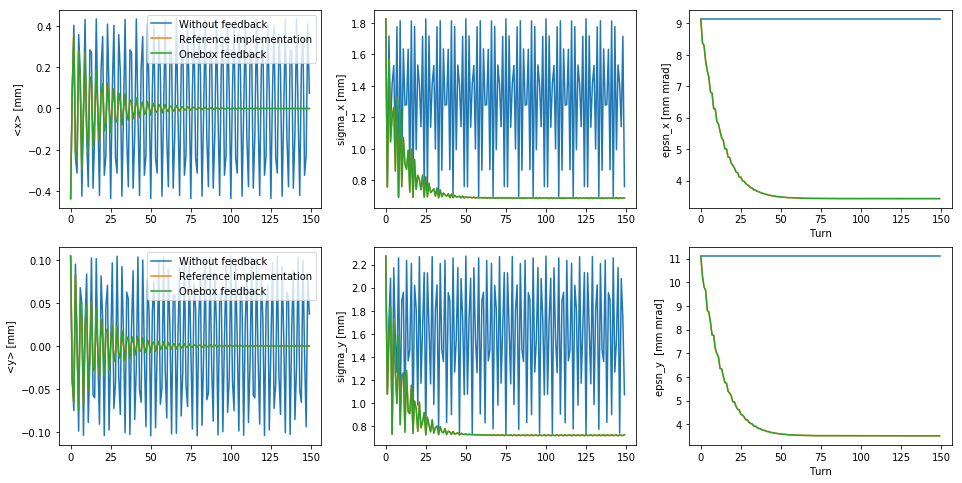

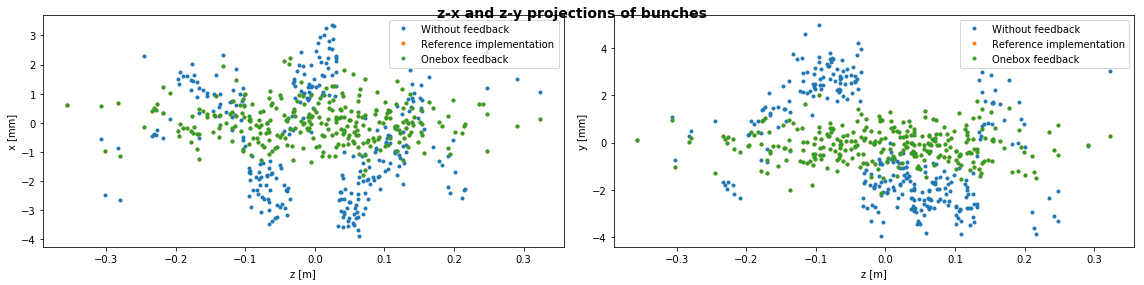


Note that the following values depend on the width of the slicing window (sigma_z for the slicer)!
An average relative particle position difference in x-axis: 0.0
An average relative particle position difference in y-axis: 0.0


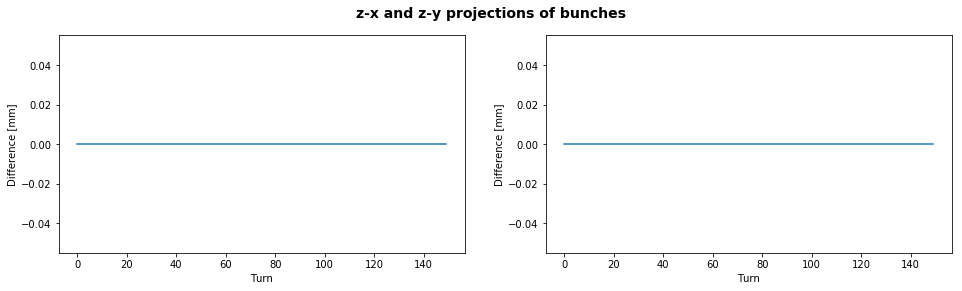

In [9]:
compare_traces([tracker_ref,tracker_IdealSliceFB,tracker_Onebox_slice],
               ['Without feedback', 'Reference implementation', 'Onebox feedback'])
compare_projections([bunch_init, bunch_IdealSliceFB, bunch_Onebox_slice], 
                    ['Without feedback', 'Reference implementation', 'Onebox feedback'])
print ''
print 'Note that the following values depend on the width of the slicing window (sigma_z for the slicer)!'
particle_position_difference(bunch_IdealSliceFB, bunch_Onebox_slice)
trace_difference(tracker_IdealSliceFB,tracker_Onebox_slice)

#### Bunch-by-bunch feedback

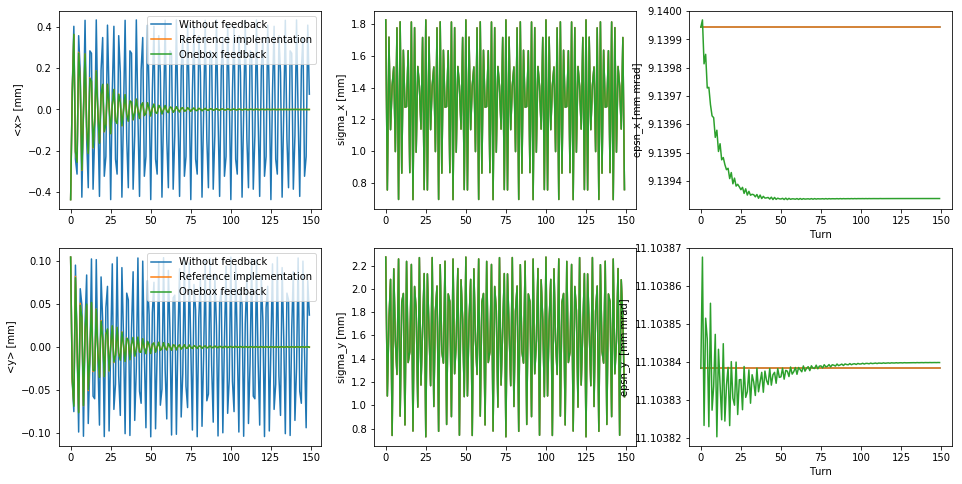

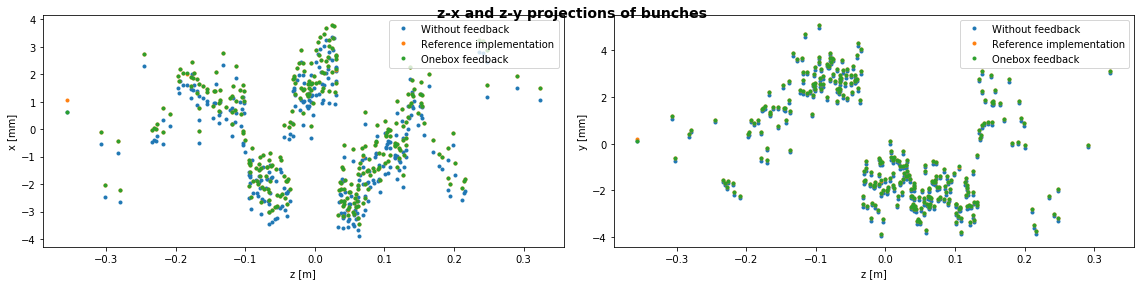


Note that the following depend on the width of the slicing window (sigma_z for the slicer)!
An average relative particle position difference in x-axis: 0.00014259389394335832
An average relative particle position difference in y-axis: 5.258411666287104e-06


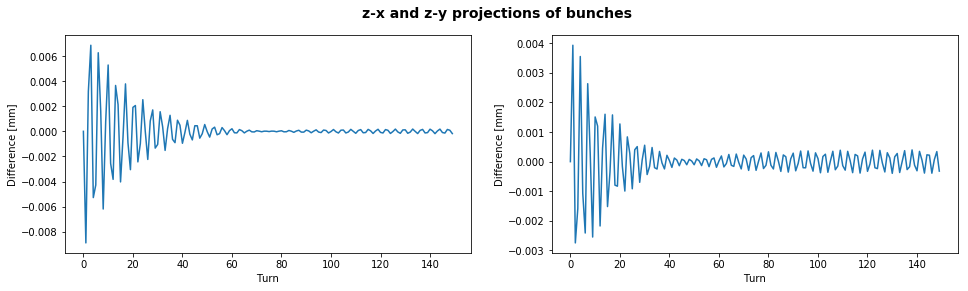

In [9]:
compare_traces([tracker_ref,tracker_IdealBunchFB, tracker_Onebox_bunch],
               ['Without feedback', 'Reference implementation', 'Onebox feedback'])
compare_projections([bunch_init,bunch_IdealBunchFB, bunch_Onebox_bunch], 
                    ['Without feedback', 'Reference implementation', 'Onebox feedback'])
print ''
print 'Note that the following depend on the width of the slicing window (sigma_z for the slicer)!'
particle_position_difference(bunch_IdealBunchFB, bunch_Onebox_bunch)
trace_difference(tracker_IdealBunchFB, tracker_Onebox_bunch)

Jani Komppula, CERN, 2017